# Feature Engineering and Modeling

This notebook handles the feature engineering, model training, and evaluation for the telco customer churn prediction project.

**Objectives:**
- Load the cleaned data
- Prepare features for modeling
- Train multiple classification models
- Evaluate and compare model performance
- Save the best performing model

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42
TEST_SPLIT_SIZE = 0.2

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the processed data
df = pd.read_csv('data/processed/churn_data_cleaned.csv')

print(f"Loaded data shape: {df.shape}")
print(f"Target distribution:")
print(df['Churn'].value_counts())
print(f"Target distribution (%):")
print(df['Churn'].value_counts(normalize=True) * 100)

Loaded data shape: (7043, 20)
Target distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Target distribution (%):
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [3]:
# Feature/Target Separation
y = df['Churn']  # Target variable
X = df.drop('Churn', axis=1)  # Features

# Target Encoding: Convert 'Yes'/'No' to 1/0
y = y.map({'Yes': 1, 'No': 0})

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution after encoding:")
print(y.value_counts())

Features shape: (7043, 19)
Target shape: (7043,)
Target distribution after encoding:
Churn
0    5174
1    1869
Name: count, dtype: int64


In [4]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SPLIT_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y  # Maintain class distribution
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution:")
print(y_train.value_counts())
print(f"Test target distribution:")
print(y_test.value_counts())

Training set shape: (5634, 19)
Test set shape: (1409, 19)
Training target distribution:
Churn
0    4139
1    1495
Name: count, dtype: int64
Test target distribution:
Churn
0    1035
1     374
Name: count, dtype: int64


In [5]:
# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fit and transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

Numerical features (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Processed training data shape: (5634, 45)
Processed test data shape: (1409, 45)


In [6]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
}

# Train models and store results
trained_models = {}
model_predictions = {}

print("Training models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_processed, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    model_predictions[name] = y_pred
    
    print(f"{name} training completed!")

Training models...

Training Logistic Regression...
Logistic Regression training completed!

Training Random Forest...
Random Forest training completed!

Training XGBoost...
XGBoost training completed!


In [7]:
# Model Evaluation
print("Model Evaluation Results:")
print("="*50)

best_f1_score = 0
best_model_name = ""
best_model = None

for name, y_pred in model_predictions.items():
    print(f"\n{name} Classification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    
    # Get F1-score for positive class (1)
    f1_score = report['1']['f1-score']
    print(f"F1-Score for churn class: {f1_score:.4f}")
    
    # Track best model
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_model_name = name
        best_model = trained_models[name]

print(f"\nBest Model: {best_model_name} with F1-Score: {best_f1_score:.4f}")

Model Evaluation Results:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

F1-Score for churn class: 0.6040

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409

F1-Score for churn class: 0.5474

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.

In [8]:
# Feature Importance Analysis
if best_model_name in ['Random Forest', 'XGBoost']:
    print(f"\nExtracting feature importance for {best_model_name}...")
    
    # Get feature importance
    importance = best_model.feature_importances_
    
    # Get feature names from preprocessor
    # Numerical features keep their names
    num_feature_names = numerical_features
    
    # Categorical features get encoded with OneHotEncoder
    cat_feature_names = []
    if len(categorical_features) > 0:
        encoder = preprocessor.named_transformers_['cat']
        cat_feature_names = encoder.get_feature_names_out(categorical_features).tolist()
    
    # Combine all feature names
    all_feature_names = num_feature_names + cat_feature_names
    
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))
    
else:
    print(f"\nFeature importance not available for {best_model_name}")
    print("Feature importance is only available for tree-based models.")


Feature importance not available for Logistic Regression
Feature importance is only available for tree-based models.



Generating feature importance using Random Forest model...


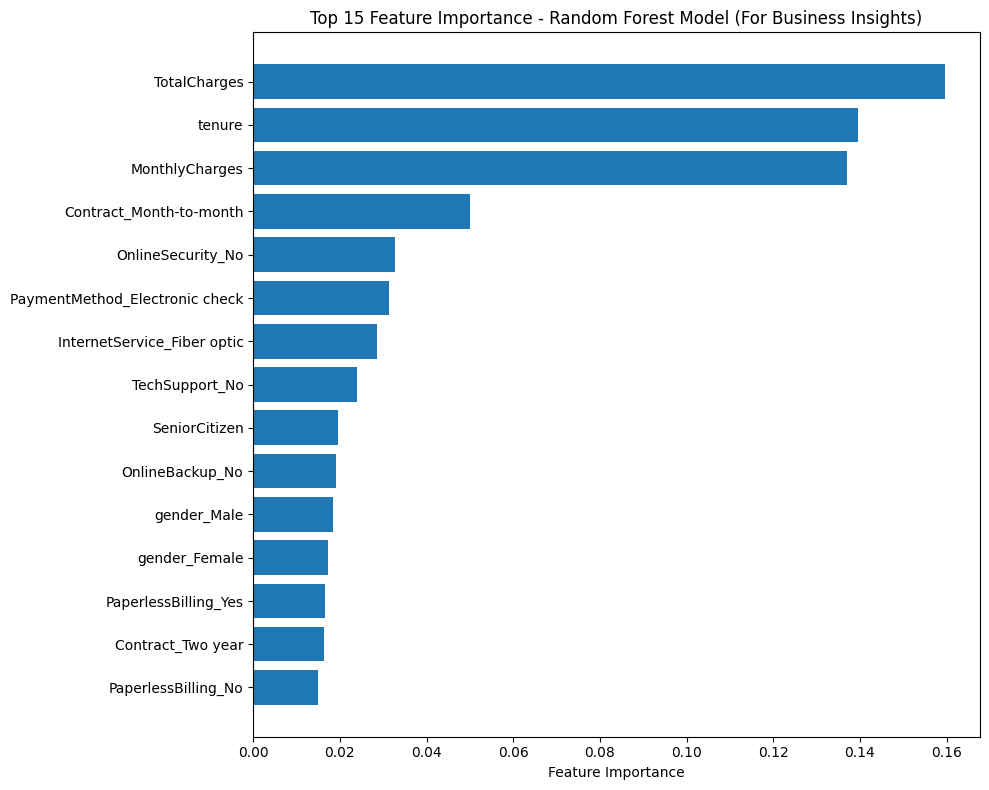


Top 10 Most Important Features (Random Forest):
                           feature  importance
3                     TotalCharges    0.159723
1                           tenure    0.139577
2                   MonthlyCharges    0.137054
36         Contract_Month-to-month    0.049974
18               OnlineSecurity_No    0.032827
43  PaymentMethod_Electronic check    0.031370
16     InternetService_Fiber optic    0.028670
27                  TechSupport_No    0.024004
0                    SeniorCitizen    0.019575
21                 OnlineBackup_No    0.019111


In [9]:
# Generate feature importance for Random Forest (for business insights)
print(f"\nGenerating feature importance using Random Forest model...")

rf_model = trained_models['Random Forest']
importance = rf_model.feature_importances_

# Get feature names from preprocessor
# Numerical features keep their names
num_feature_names = numerical_features

# Categorical features get encoded with OneHotEncoder
cat_feature_names = []
if len(categorical_features) > 0:
    encoder = preprocessor.named_transformers_['cat']
    cat_feature_names = encoder.get_feature_names_out(categorical_features).tolist()

# Combine all feature names
all_feature_names = num_feature_names + cat_feature_names

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top 15 Feature Importance - Random Forest Model (For Business Insights)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance_df.head(10))

In [10]:
# Save the best model
model_path = 'models/best_churn_model.pkl'

# Create a model package that includes both the model and preprocessor
model_package = {
    'model': best_model,
    'preprocessor': preprocessor,
    'model_name': best_model_name,
    'f1_score': best_f1_score,
    'feature_names': {
        'numerical': numerical_features,
        'categorical': categorical_features
    }
}

joblib.dump(model_package, model_path)

print(f"Best model ({best_model_name}) saved to: {model_path}")
print(f"Model F1-Score: {best_f1_score:.4f}")
print(f"Model package includes:")
print("- Trained model")
print("- Preprocessing pipeline")
print("- Model metadata")

Best model (Logistic Regression) saved to: models/best_churn_model.pkl
Model F1-Score: 0.6040
Model package includes:
- Trained model
- Preprocessing pipeline
- Model metadata
